# Projeto de Controle Digital — Exemplo Fly-by-Wire (Cap. 13 — Dorf & Bishop)

Compensador digital para um sistema de superfície de controle *fly-by-wire*.

---

## Objetivo

Projetar um controlador digital $( D(z))$ que faça o ângulo da superfície de controle $( \theta(t) )$
seguir adequadamente o comando do piloto $( r(t) )$, atendendo critérios de:

- **Precisão dinâmica**
- **Estabilidade em tempo discreto**
- **Tempo de acomodação adequado**
- **Máxima ultrapassagem limitada**

---

## Planta do sistema (contínua)

A dinâmica da superfície de controle é modelada como:

$[
G_p(s) = \frac{1}{s(s+1)}
$]

O sistema é discretizado usando:

- **Retenção de ordem zero (ZOH)**  
- **Período de amostragem** $( T = 0.1\,\text{s} )$

---

## Estratégia do projeto

1. Discretizar a planta: obter $( G(z) )$
2. Avaliar se o controlador proporcional \( D(z)=K \) atende os requisitos
3. Projetar um compensador digital de **avanço em \(z\)**:

$[
D(z) = K \frac{z - a}{z - b}, \quad |a| < |b|
$]

4. Ajustar $( K, a, b )$ usando:
- Lugar das raízes no plano-\(z\)
- Análise do círculo unitário
- Requisitos de ultrapassagem e tempo de acomodação

5. Validar o sistema em malha fechada com simulações de degrau.



In [7]:
import numpy as np
import control as ctl
import matplotlib.pyplot as plt

# parâmetros
T = 0.1  # período de amostragem

# Planta contínua
s = ctl.TransferFunction.s
Gp = 1 / (s*(s+1))

# Discretização ZOH
Gz = ctl.sample_system(Gp, T, method='zoh')

print("G(z) discretizado:")
Gz


G(z) discretizado:


TransferFunction(
array([0.00483742, 0.00467884]),
array([ 1.        , -1.90483742,  0.90483742]),
dt=0.1,
name='sys[491]$sampled', outputs=1, inputs=1)

## Discretização da Planta

Usamos a transformação ZOH:

$[
G(z) = \mathcal{Z} \left\{ \frac{1 - e^{-sT}}{s} G_p(s) \right\}
$]

Para $( T = 0.1 )$ s, o livro obtém:

$$[
G(z) \approx \frac{0.004837z + 0.004069}{(z - 1)(z - 0.9048)}
]$$

Após executar a célula anterior, verificamos se a forma numérica obtida é equivalente.


In [9]:
# 4) Verificar estabilidade e polos da malha fechada para alguns ganhos K

def closed_loop_K(K):
    D = K                       # controlador proporcional
    L = ctl.series(D, Gz)       # malha aberta
    Tz = ctl.feedback(L, 1)     # malha fechada
    return Tz

for K in [5, 20, 50, 100]:
    Tz = closed_loop_K(K)
    poles = Tz.poles()
    print(f"K={K}: polos = {poles}")


K=5: polos = [0.94032516+0.20980993j 0.94032516-0.20980993j]
K=20: polos = [0.90404453+0.42557927j 0.90404453-0.42557927j]
K=50: polos = [0.83148326+0.66889089j 0.83148326-0.66889089j]
K=100: polos = [0.71054781+0.93158105j 0.71054781-0.93158105j]


## Controlador de avanço digital

O compensador usado no livro é:

$[
D(z) = K\,\frac{z-a}{z-b}
]$

Escolhas sugeridas:

$[
a = 0.9048, \qquad b = -0.25
]$

$[
K \approx 70
]$

Essa estrutura introduz um avanço de fase no plano-\(z\), deslocando o lugar das raízes
para atender os requisitos:

- M.U.P. ≤ 5%
- Tempo de acomodação \( T_s < 1 \) s (≈ 10 amostras)


In [12]:
# parâmetros do compensador
a = 0.9048
b = -0.25

def Dz(K, a=a, b=b):
    """
    Retorna o compensador discreto:
        D(z) = K * (z - a) / (z - b)
    como uma TransferFunction discreta com dt = T.
    """
    num = [K, -K*a]     # K*z - K*a
    den = [1.0, -b]     # z - b
    return ctl.TransferFunction(num, den, T)

def closed_loop_full(K):
    """
    Monta L(z) = D(z)*G(z) e devolve T(z) = L(z)/(1+L(z)).
    """
    Dz_tf = Dz(K)
    Lz = ctl.series(Dz_tf, Gz)
    Tz = ctl.feedback(Lz, 1)
    return Tz

# polos para o K = 70 (valor usado no livro)
Tz_70 = closed_loop_full(70)
polos_70 = Tz_70.poles()

print("Polos de T(z) para K=70:")
print(polos_70)


Polos de T(z) para K=70:
[0.90479215+0.j         0.205713  +0.18759346j 0.205713  -0.18759346j]


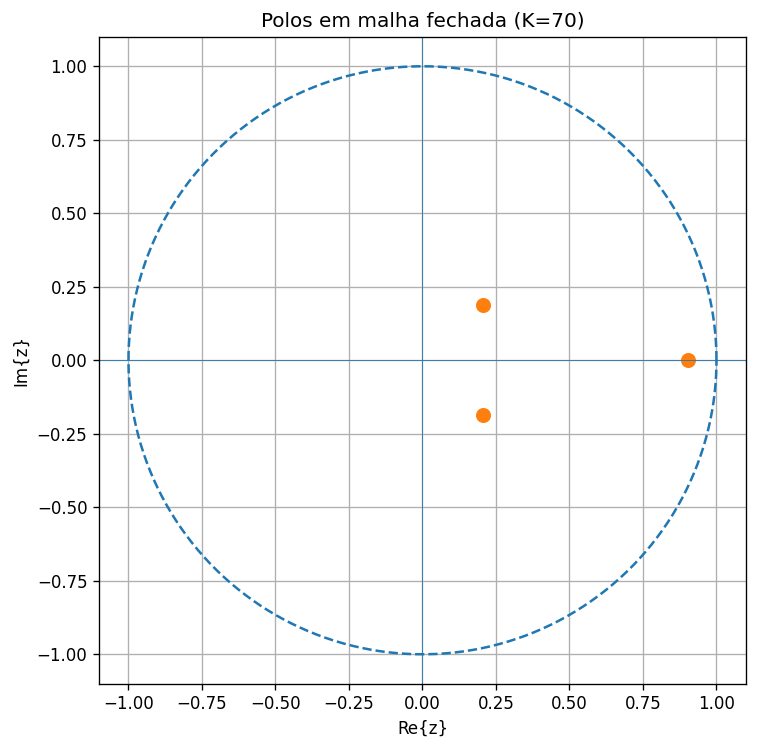

In [14]:
# círculo unitário
θ = np.linspace(0, 2*np.pi, 400)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(np.cos(θ), np.sin(θ), '--')   # círculo unitário

# polos do sistema compensado (K = 70)
p = np.array(Tz_70.poles(), dtype=complex)

# plota cada polo
ax.plot(np.real(p), np.imag(p), 'o', markersize=8)

# eixos e formatação
ax.axhline(0, lw=0.5)
ax.axvline(0, lw=0.5)
ax.set_aspect('equal')
ax.set_xlabel("Re{z}")
ax.set_ylabel("Im{z}")
ax.set_title("Polos em malha fechada (K=70)")
plt.grid(True)
plt.show()


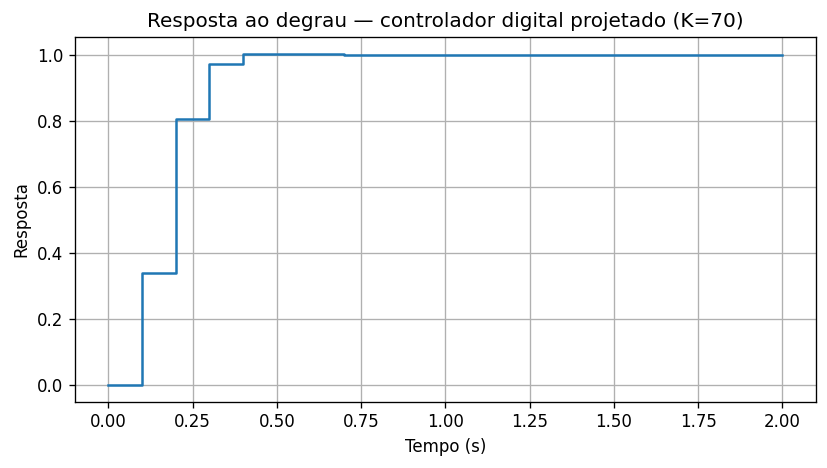

In [15]:
# horizonte de simulação: 0 a 2 s com passo T
t = np.arange(0, 2 + T/2, T)   # inclui o último ponto aproximadamente

# usar step_response com vetor de instantes (funciona para TF discretos)
t_out, y_out = ctl.step_response(Tz_70, T=t)

# y_out pode vir com shape (n,) ou (n,1) ou (1,n); usamos squeeze para garantir 1D
y = np.squeeze(y_out)

plt.figure(figsize=(7,4))
plt.step(t_out, y, where='post')
plt.xlabel("Tempo (s)")
plt.ylabel("Resposta")
plt.title("Resposta ao degrau — controlador digital projetado (K=70)")
plt.grid(True)
plt.tight_layout()
plt.show()
